In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks")



# 1. 载入相关库

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
from torch.autograd import Variable
import copy
import torch.utils.data as Data
import pandas as pd
from sklearn.metrics import accuracy_score,f1_score,roc_curve,precision_recall_curve,average_precision_score,auc
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix,matthews_corrcoef,roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import random

# 2. 处理数据

In [4]:
#数据处理 读取数据
test_npy = np.load('test.npy')
train_npy = np.load('train.npy')
#图片数量
train_num = len(train_npy)
test_num = len(test_npy)
print(train_num)
print(test_num)
#转为28x28的ndarray
test_npy = np.reshape(test_npy,(test_num,28,28))
train_npy = np.reshape(train_npy,(train_num,28,28))

#resize改变图像大小
train_all = []
test_img = []
for i in range(train_num):
    train_all.append(Image.fromarray(train_npy[i,...]))
    train_all[i] = train_all[i].resize((112,112))
for j in range(test_num):
    test_img.append(Image.fromarray(test_npy[j,...]))
    test_img[j] = test_img[j].resize((112,112))

val_label = np.zeros(600,dtype=int)
train_label = np.zeros(2400,dtype=int)
val_img = []
train_img = []
#划分训练集和验证集
for i in range(10):
    train_temp = train_all[3000*i:3000*(i+1)]
    #随机打乱每类图片顺序
    random.shuffle(train_temp)
    val_img.extend(train_temp[0:600])
    train_img.extend(train_temp[600:])
    if i>0:
        val_label = np.append(val_label,i*np.ones(600,dtype=np.int64))
        train_label = np.append(train_label,i*np.ones(2400,dtype=np.int64))

30000
5000


In [5]:
train_transform = transforms.Compose([transforms.RandomCrop(112, padding=4),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.ToTensor()])
#转换为张量
transform = transforms.ToTensor()
BATCH_SIZE = 64
class MyDataSet(Data.Dataset):
    def __init__(self, pic_data, label_data=None, transform=None, type = 'train'):  # 第一步初始化各个变量
        self.pic_data = pic_data #导入所有数据
        self.label_data = label_data
        self.type = type
        self.transform = transform
    def __getitem__(self, idx):  # 获取数据
        img = self.pic_data[idx]
        data = self.transform(img)
        if self.type == 'test':
            return data
        else:
            label = self.label_data[idx]
            return data,label
    def __len__(self):
        return len(self.pic_data)  # 返回数据集长度
#导入数据集
train_dataset = MyDataSet(train_img,train_label,train_transform, type = 'train')
val_dataset = MyDataSet(val_img,val_label,test_transform, type = 'train')
test_dataset = MyDataSet(test_img,transform = test_transform, type = 'test')
#加载小批次数据，即将数据集中的data分成每组batch_size的小块，shuffle指定是否随机读取
train_loader = Data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = Data.DataLoader(dataset=val_dataset,batch_size=BATCH_SIZE,shuffle=False)
test_loader = Data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)
print("train_loader:", len(train_loader))
print("val_loader:", len(val_loader))
print("test_loader:", len(test_loader))

train_loader: 375
val_loader: 94
test_loader: 79


# 3.定义残差模块

In [0]:
#参考:https://www.cnblogs.com/wzyuan/p/9880342.html
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        #输入输出维度一致时直接相加
        self.downsample = nn.Sequential()
        #维度不一致时
        if stride != 1 or inchannel != outchannel:
            #1X1卷积核改变维度
            self.downsample = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        residual = self.left(x)
        out = self.downsample(x)
        out = out + residual
        out = F.relu(out)
        return out

# 4. 定义网络

In [0]:



class ResNet(nn.Module):
    def __init__(self, ResidualBlock):
        #预先处理
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, bias=False)
        self.batch_norm = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        #输入维度
        self.in_channel = 64
        #残差模块
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc1 = nn.Linear(512, 10)

    #残差层，每层有两个残差模块
    def make_layer(self, block, channels, num_blocks, stride):
        layers = []
        #第一个模块
        layers.append(block(self.in_channel, channels, stride))
        self.in_channel = channels
        #第二个模块，stride=1，不需要downsample
        layers.append(block(self.in_channel, channels, 1))
        return nn.Sequential(*layers)

    #网络的前向传播函数
    def forward(self, x):
        out = self.conv1(x)
        out = self.batch_norm(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)              
        return out

def ResNet18():
    return ResNet(ResidualBlock)


# 5. 训练模型

## 5.1定义网络与参数

In [0]:
model = ResNet18().cuda() #实例化网络
#model = ResNet18() #实例化网络
loss = nn.CrossEntropyLoss() #损失函数选择，交叉熵函数
optimizer = optim.SGD(model.parameters(),lr = 0.05,weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
num_epochs = 30
#训练和验证集的准确率和损失值
train_losses = []
train_acces = []
val_losses = []
val_acces = []

## 5.2训练模型

In [10]:
#训练和验证集的准确率和损失值
for echo in range(num_epochs):
    train_loss = 0  # 定义训练损失
    train_acc = 0  # 定义训练准确度
    model.train()  # 将网络转化为训练模式
    train_loader = tqdm(train_loader)
    scheduler.step()
    lr = scheduler.get_lr()
    print("lr:", lr)
    for i, (X, label) in enumerate(train_loader):  # 使用枚举函数遍历train_loader
        X = Variable(X).cuda()  #转化数据类型
        X = X.float()
        label = Variable(label).cuda()
        out = model(X)  # 正向传播
        lossvalue = loss(out, label)  # 求损失值
        optimizer.zero_grad()  # 优化器梯度归零
        lossvalue.backward()  # 反向转播，刷新梯度值
        optimizer.step()  # 优化器运行一步，注意optimizer搜集的是model的参数
        # 计算损失
        train_loss += float(lossvalue)
        # 计算精确度
        _, pred = out.max(1)
        num_correct = (pred == label).sum()
        acc = int(num_correct) / X.shape[0]
        train_acc += acc
    train_losses.append(train_loss / len(train_loader))
    train_acces.append(train_acc / len(train_loader))
    print("train epoch:" + ' ' + str(echo))
    print("lose:" + ' ' + str(train_loss / len(train_loader)))
    print("accuracy:" + ' ' + str(train_acc / len(train_loader)))

    val_pred = None #预测分类
    val_label_all = None #实际分类
    val_pred_pro_all = None #对应概率
    val_loss = 0  # 定义验证损失
    val_acc = 0
    model.eval() #模型转化为评估模式
    # val_loader = tqdm(val_loader)
    for X,label in val_loader:
        X = Variable(X).cuda()
        X = X.float()
        label = Variable(label).cuda()
        with torch.no_grad():
            testout = model(X)
        testloss = loss(testout,label)
        val_loss += float(testloss)
        _, pred = testout.max(1)
        if val_pred is None:
            val_pred = torch.cat([pred])
        else:
            val_pred = torch.cat([val_pred, pred])
        if val_label_all is None:
            val_label_all = label
        else:
            val_label_all = torch.cat([val_label_all, label])
        if val_pred_pro_all is None:
            val_pred_pro_all = torch.cat([F.sigmoid(testout)])
        else:
            val_pred_pro_all = torch.cat([val_pred_pro_all, F.sigmoid(testout)])
        num_correct = (pred == label).sum()
        acc = int(num_correct) / X.shape[0]
        val_acc += acc
    val_losses.append(val_loss / len(val_loader))
    val_acces.append(val_acc / len(val_loader))
    print("val epoch:" + ' ' + str(echo))
    print("lose:" + ' ' + str(val_loss / len(val_loader)))
    print("accuracy:" + ' ' + str(val_acc / len(val_loader)))

  0%|          | 0/375 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


lr: [0.05]


100%|██████████| 375/375 [01:00<00:00,  6.00it/s]
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train epoch: 0
lose: 0.7763575422763824
accuracy: 0.7113333333333334


  0%|          | 1/375 [00:00<01:02,  5.98it/s]

val epoch: 0
lose: 0.5969313316919068
accuracy: 0.7623005319148937
lr: [0.05]


100%|██████████| 375/375 [01:01<00:00,  6.13it/s]


train epoch: 1
lose: 0.49579543085892996
accuracy: 0.8130833333333334


  0%|          | 1/375 [00:00<01:01,  6.09it/s]

val epoch: 1
lose: 0.4343471490639321
accuracy: 0.8403701241134752
lr: [0.05]


100%|██████████| 375/375 [01:01<00:00,  6.08it/s]


train epoch: 2
lose: 0.4147681130965551
accuracy: 0.8460833333333333


  0%|          | 1/375 [00:00<01:01,  6.13it/s]

val epoch: 2
lose: 0.43793495253045506
accuracy: 0.842364804964539
lr: [0.05]


100%|██████████| 375/375 [01:01<00:00,  6.05it/s]


train epoch: 3
lose: 0.3691329933802287
accuracy: 0.8615833333333334


  0%|          | 1/375 [00:00<01:02,  5.99it/s]

val epoch: 3
lose: 0.37283912067242125
accuracy: 0.8611480496453902
lr: [0.05]


100%|██████████| 375/375 [01:01<00:00,  6.14it/s]


train epoch: 4
lose: 0.3338557516336441
accuracy: 0.874875


  0%|          | 1/375 [00:00<01:00,  6.15it/s]

val epoch: 4
lose: 0.39647609575532694
accuracy: 0.852061170212766
lr: [0.05]


100%|██████████| 375/375 [01:01<00:00,  6.02it/s]


train epoch: 5
lose: 0.31467242989937466
accuracy: 0.8830416666666666


  0%|          | 1/375 [00:00<01:04,  5.82it/s]

val epoch: 5
lose: 0.32474874457384045
accuracy: 0.8794880319148937
lr: [0.05]


100%|██████████| 375/375 [01:01<00:00,  6.02it/s]


train epoch: 6
lose: 0.29063542213042576
accuracy: 0.894375


  0%|          | 1/375 [00:00<01:01,  6.10it/s]

val epoch: 6
lose: 0.5509566942110975
accuracy: 0.7902260638297872
lr: [0.05]


100%|██████████| 375/375 [01:01<00:00,  6.03it/s]


train epoch: 7
lose: 0.27734573918581007
accuracy: 0.8957916666666667


  0%|          | 1/375 [00:00<01:02,  6.02it/s]

val epoch: 7
lose: 0.36280240646583284
accuracy: 0.8696808510638298
lr: [0.05]


100%|██████████| 375/375 [01:01<00:00,  6.09it/s]


train epoch: 8
lose: 0.26012470996379855
accuracy: 0.9049583333333333


  0%|          | 1/375 [00:00<01:00,  6.16it/s]

val epoch: 8
lose: 0.3142170756658975
accuracy: 0.8847517730496455
lr: [0.005000000000000001]


100%|██████████| 375/375 [01:01<00:00,  6.14it/s]


train epoch: 9
lose: 0.20100194960832596
accuracy: 0.9262916666666666


  0%|          | 1/375 [00:00<01:01,  6.07it/s]

val epoch: 9
lose: 0.26853967620495783
accuracy: 0.9022606382978723
lr: [0.005000000000000001]


100%|██████████| 375/375 [01:01<00:00,  6.10it/s]


train epoch: 10
lose: 0.18663159177700678
accuracy: 0.9324166666666667


  0%|          | 1/375 [00:00<01:00,  6.21it/s]

val epoch: 10
lose: 0.26005327107107384
accuracy: 0.9065824468085106
lr: [0.005000000000000001]


100%|██████████| 375/375 [01:01<00:00,  6.05it/s]


train epoch: 11
lose: 0.18163607774178187
accuracy: 0.9345416666666667


  0%|          | 1/375 [00:00<01:01,  6.07it/s]

val epoch: 11
lose: 0.26048556792529975
accuracy: 0.9070811170212766
lr: [0.005000000000000001]


100%|██████████| 375/375 [01:01<00:00,  6.04it/s]


train epoch: 12
lose: 0.17364161998033523
accuracy: 0.9372083333333333


  0%|          | 1/375 [00:00<01:01,  6.04it/s]

val epoch: 12
lose: 0.2654937700903479
accuracy: 0.9060837765957447
lr: [0.005000000000000001]


100%|██████████| 375/375 [01:01<00:00,  6.08it/s]


train epoch: 13
lose: 0.16727097461620966
accuracy: 0.9410416666666667


  0%|          | 1/375 [00:00<01:00,  6.23it/s]

val epoch: 13
lose: 0.25871890470227027
accuracy: 0.9097406914893617
lr: [0.005000000000000001]


100%|██████████| 375/375 [01:01<00:00,  6.04it/s]


train epoch: 14
lose: 0.16208391762773197
accuracy: 0.9414166666666667


  0%|          | 1/375 [00:00<01:00,  6.16it/s]

val epoch: 14
lose: 0.2570850495050879
accuracy: 0.9100731382978723
lr: [0.005000000000000001]


100%|██████████| 375/375 [01:01<00:00,  6.08it/s]


train epoch: 15
lose: 0.16095968981583914
accuracy: 0.9409166666666666


  0%|          | 1/375 [00:00<01:00,  6.14it/s]

val epoch: 15
lose: 0.2580625485192905
accuracy: 0.9084109042553191
lr: [0.005000000000000001]


100%|██████████| 375/375 [01:01<00:00,  6.04it/s]


train epoch: 16
lose: 0.1564586305220922
accuracy: 0.9434583333333333


  0%|          | 1/375 [00:00<01:00,  6.13it/s]

val epoch: 16
lose: 0.25729617934198457
accuracy: 0.9070811170212766
lr: [0.005000000000000001]


100%|██████████| 375/375 [01:01<00:00,  6.11it/s]


train epoch: 17
lose: 0.15269470803936322
accuracy: 0.9445833333333333


  0%|          | 1/375 [00:00<01:02,  5.95it/s]

val epoch: 17
lose: 0.25589103453812445
accuracy: 0.9105718085106383
lr: [0.005000000000000001]


100%|██████████| 375/375 [01:01<00:00,  6.12it/s]


train epoch: 18
lose: 0.14664288019140562
accuracy: 0.9462916666666666


  0%|          | 1/375 [00:00<01:00,  6.19it/s]

val epoch: 18
lose: 0.25907083260925845
accuracy: 0.9115691489361702
lr: [0.0005000000000000001]


100%|██████████| 375/375 [01:01<00:00,  6.12it/s]


train epoch: 19
lose: 0.1368534607589245
accuracy: 0.9529166666666666


  0%|          | 1/375 [00:00<01:01,  6.07it/s]

val epoch: 19
lose: 0.2575955660419261
accuracy: 0.9102393617021277
lr: [0.0005000000000000001]


100%|██████████| 375/375 [01:01<00:00,  6.08it/s]


train epoch: 20
lose: 0.13640305015444756
accuracy: 0.9517916666666667


  0%|          | 1/375 [00:00<01:00,  6.18it/s]

val epoch: 20
lose: 0.25712673334365194
accuracy: 0.9110704787234043
lr: [0.0005000000000000001]


100%|██████████| 375/375 [01:01<00:00,  6.14it/s]


train epoch: 21
lose: 0.13482331287860871
accuracy: 0.9527916666666667


  0%|          | 1/375 [00:00<01:01,  6.08it/s]

val epoch: 21
lose: 0.2568261006728132
accuracy: 0.9117353723404256
lr: [0.0005000000000000001]


100%|██████████| 375/375 [01:01<00:00,  6.05it/s]


train epoch: 22
lose: 0.13423571313420932
accuracy: 0.9519166666666666


  0%|          | 1/375 [00:00<01:01,  6.09it/s]

val epoch: 22
lose: 0.2570029691535425
accuracy: 0.9110704787234043
lr: [0.0005000000000000001]


100%|██████████| 375/375 [01:01<00:00,  6.08it/s]


train epoch: 23
lose: 0.1308183692097664
accuracy: 0.954875


  0%|          | 1/375 [00:00<01:01,  6.07it/s]

val epoch: 23
lose: 0.25787137803482885
accuracy: 0.9115691489361702
lr: [0.0005000000000000001]


100%|██████████| 375/375 [01:01<00:00,  6.11it/s]


train epoch: 24
lose: 0.13216973467667897
accuracy: 0.953375


  0%|          | 1/375 [00:00<01:02,  5.98it/s]

val epoch: 24
lose: 0.2566561765295077
accuracy: 0.9110704787234043
lr: [0.0005000000000000001]


100%|██████████| 375/375 [01:01<00:00,  6.03it/s]


train epoch: 25
lose: 0.1326141787469387
accuracy: 0.952875


  0%|          | 1/375 [00:00<01:02,  6.01it/s]

val epoch: 25
lose: 0.2574522529550372
accuracy: 0.9117353723404256
lr: [0.0005000000000000001]


100%|██████████| 375/375 [01:01<00:00,  6.06it/s]


train epoch: 26
lose: 0.13117844332257905
accuracy: 0.9538333333333333


  0%|          | 1/375 [00:00<01:02,  6.02it/s]

val epoch: 26
lose: 0.25673305239290634
accuracy: 0.9115691489361702
lr: [0.0005000000000000001]


100%|██████████| 375/375 [01:01<00:00,  6.08it/s]


train epoch: 27
lose: 0.13194198016325634
accuracy: 0.9526666666666667


  0%|          | 1/375 [00:00<01:01,  6.08it/s]

val epoch: 27
lose: 0.2579998544892891
accuracy: 0.9115691489361702
lr: [0.0005000000000000001]


100%|██████████| 375/375 [01:01<00:00,  6.16it/s]


train epoch: 28
lose: 0.12984188042084377
accuracy: 0.9539583333333334


  0%|          | 1/375 [00:00<01:01,  6.09it/s]

val epoch: 28
lose: 0.2572556381965888
accuracy: 0.9125664893617021
lr: [5.0000000000000016e-05]


100%|██████████| 375/375 [01:01<00:00,  6.04it/s]


train epoch: 29
lose: 0.12893843877315522
accuracy: 0.9555
val epoch: 29
lose: 0.2568023958778445
accuracy: 0.9122340425531915


In [11]:
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.05
    lr: 5.0000000000000016e-05
    momentum: 0
    nesterov: False
    weight_decay: 0.0001
)


## 5.3 验证集准确率计算

ACC:0.9120000
Precision-macro:0.9122511
Recall-macro:0.9120000
F1-macro:0.9120943


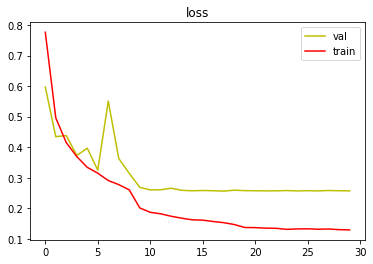

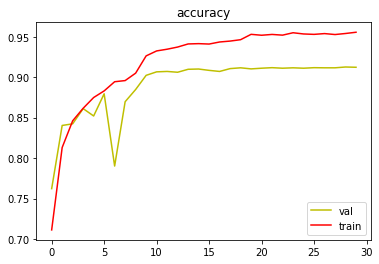

In [12]:

y_val = val_label_all.cpu().detach().numpy()
y_val_pred = val_pred.cpu().detach().numpy()
y_pred_pro = val_pred_pro_all.cpu().detach().numpy()
print('ACC:%.7f' %accuracy_score(y_true=y_val, y_pred=y_val_pred))
print('Precision-macro:%.7f' %precision_score(y_true=y_val, y_pred=y_val_pred,average='macro'))
print('Recall-macro:%.7f' %recall_score(y_true=y_val, y_pred=y_val_pred,average='macro'))
print('F1-macro:%.7f' %f1_score(y_true=y_val, y_pred=y_val_pred,average='macro'))   
plt.figure()
plt.plot(val_losses, label = 'val', color='y')
plt.plot(train_losses,label='train', color='r')
plt.title('loss')
plt.legend(loc="upper right")
plt.figure()
plt.plot(val_acces, label = 'val', color='y')
plt.plot(train_acces,label='train', color='r')
plt.title('accuracy')
plt.legend(loc="lower right")

## 5.4 作图

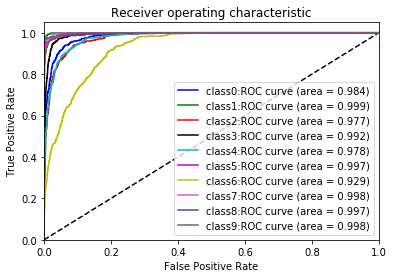

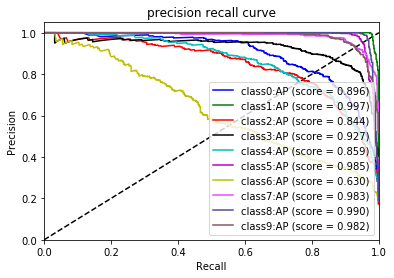

In [13]:
#参考助教ai_turorial2.ipynb
fpr = dict()
tpr = dict()
roc_auc = dict()
average_precision = dict()
recall = dict()
precision = dict()
for i in range(10):
    y_test2 = copy.deepcopy(y_val)
    y_test2[y_test2!=i] = 10
    y_test2[y_test2==i] = 1
    y_test2[y_test2==10] = 0
    y_pred_pro2 = y_pred_pro[:,i]
    
    fpr[i], tpr[i], _ = roc_curve(y_test2, y_pred_pro2)
    #面积
    roc_auc[i] = roc_auc_score(y_test2,y_pred_pro2)
    #PR曲线
    average_precision[i] = average_precision_score(y_test2, y_pred_pro2)
    precision[i], recall[i], _ = precision_recall_curve(y_test2,y_pred_pro2)

# Plot of a ROC curve for a specific class
colors = ['b','g','r','k','c','m','y','#e24fff','#524C90','#845868']
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
for i in range(10):
    plt.plot(fpr[i], tpr[i], label="class" + str(i) + ':ROC curve (area = %0.3f)' % roc_auc[i],color=colors[i])
plt.legend(loc="lower right")

# Plot of a PR curve for a specific class
colors = ['b','g','r','k','c','m','y','#e24fff','#524C90','#845868']
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('precision recall curve')
for i in range(10):
    plt.plot(recall[i], precision[i], label="class" + str(i) + ':AP (score = %0.3f)' % average_precision[i],color=colors[i])
plt.legend(loc="lower right")

# 6.分类

In [0]:
#训练模型
pred_all = None
model.eval() #模型转化为评估模式
for X in test_loader:
    X = Variable(X).cuda()
    X = X.float()
    testout = model(X)
    _, pred = testout.max(1)
    if pred_all is None:
        pred_all = torch.cat([pred])
    else:
        pred_all = torch.cat([pred_all,pred])




## 7. 结果输出

In [15]:
#结果格式转化
y_pred = pred_all.cpu().detach().numpy()
y_imagid = np.arange(5000)
y_result = np.vstack((y_imagid,y_pred))
y_result = y_result.transpose()
y_output = pd.DataFrame(y_result)
print(y_output)
y_output.columns = ['image_id', 'label']
#csv存储
y_output.to_csv('output.csv',index=False)
print(y_pred)

         0  1
0        0  7
1        1  4
2        2  3
3        3  8
4        4  1
...    ... ..
4995  4995  2
4996  4996  5
4997  4997  3
4998  4998  7
4999  4999  3

[5000 rows x 2 columns]
[7 4 3 ... 3 7 3]
